# [USPPPM] Simple RoBERTa starter (Eng/Jpn)

This competition is offered by The U.S. Patent and Trademark Office (USPTO), and aims to predict the "semantic similarity" between two key phrases.  
At first, I was a bit confused "what is the semantic similarity??", but came to understand after reading the below example of "Cape Cod" and "Bird" described in Data Description.  

今回のお題は米国特許商標庁から、「特許文献のキーフレーズ間の意味的な類似性」を予測するというものです。  
「意味的な類似性って何？？」と思いましたが、Data Descriptionに挙げられている例を調べてみて、理解しました。
> Example
For example, while the phrases "bird" and "Cape Cod" may have low semantic similarity in normal language, the likeness of their meaning is much closer if considered in the context of "house".  
例えば、「鳥」と「ケープコッド」という語句は、通常の言語では意味的類似性が低いかもしれないが、「家」の文脈で考えると、その意味の類似性ははるかに近い。

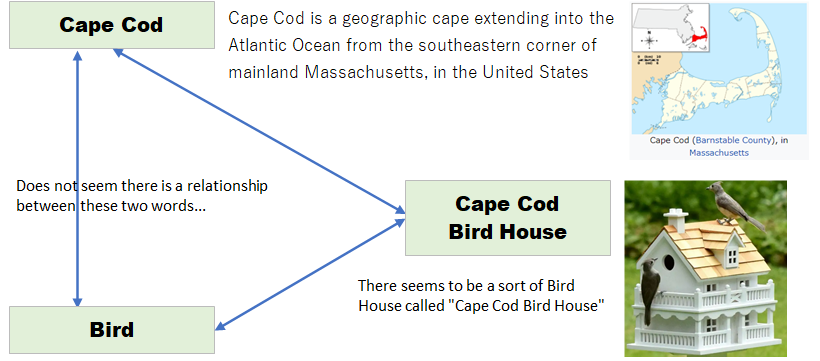

"Cape Cod" and "Bird" don't seem to hve any relationship at a glance. However, when we think about based on the Context "House" they comes to have relationship since there is a sort of Birdhouse called "Cape Cod Bird House".  
Like this, the purpose of this competition is to predict the similarity between key phrases ("Anchor" and "Target") using Context (looks like used as "patent categories" in this competition). 

一見全く関係ない「Cape Cod」（米国マサチューセッツ州の半島）と「Bird」という言葉も「House」という文脈を介して、Cape Cod Bird Houseという巣箱の一種として認識すると関係性のある言葉だ、ということになります。  
このように、特許審査を行う際に出てくるキーフレーズ（「Anchor」と「Target」）を文脈（Context。ここでは「特許の分野」という意味で使われているようです）を介して類似性を予測する、というお題のようです。

# (Preparation)

When you create a new notebook from scratch, you will need to add two databases "roberta-base" and "cpc-codes" in advance.  
新しいNotebookから始める場合は「roberta-base」と「cpc-codes」の２つのデータベースをAddしておく必要があります。  
1. Press "Add" button (Upper-right hand side of the notebook screen)
2. Search by the word "roberta", then you'd find the yellow icon "roberta-base"
3. Press "Add" then it will be added into your notebook.
   Similarly, you need to add CPC-codes as well ("cooperative" would be good as search word)

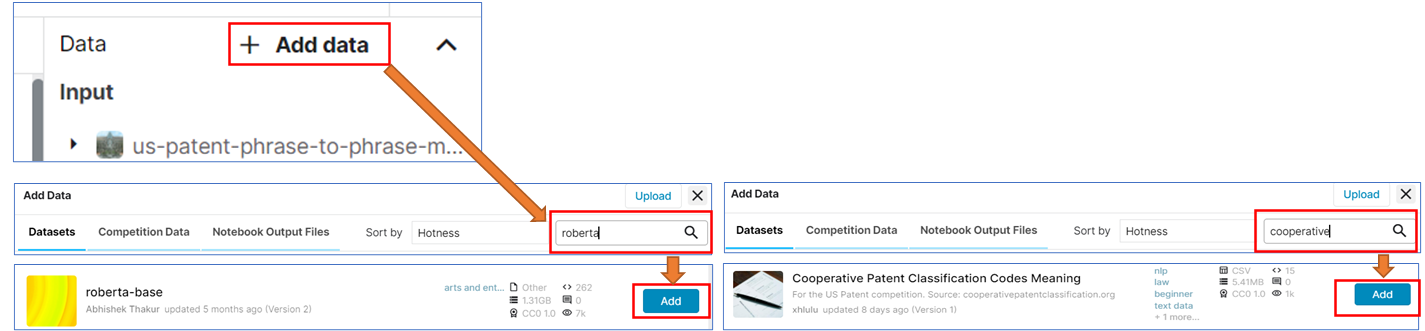

# (1) Read Data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import transformers
from transformers import RobertaTokenizer, TFRobertaModel
transformers.logging.set_verbosity_error()
import re
pd.set_option("display.max_columns", None)

In [ ]:
train_df = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv")
test_df  = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv")
train_df

In [ ]:
train_df["context"].unique()

Context number such as A47, B31 means patent categories which USTPO classified.  
You'd find the original materials published in USTPO Homepage, but they are divided as hudreds of documents and hard to use for data analysis...

Context（文脈）として与えられているA47、B31といった番号は、米国特許商標庁が分類している特許分野の分野カテゴリーの番号。  
特許商標庁のホームページを見るとサブクラス単位に分かれた文書が何百も掲載されていて使いにくい。。

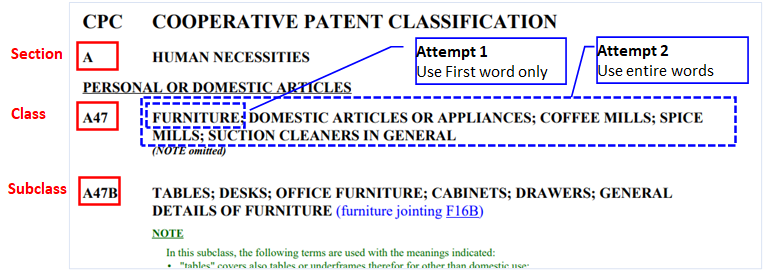

As xhlulu consolidated hundreds of USTPO categories into a single csv as a public dataset, I'm happy to use it.

xhluluさんが以下のリンク先で、何百ものUSTPOの分野カテゴリーを一つのcsvに纏めてくれたものを公開しているので、有り難く使わせていただく。

https://www.kaggle.com/datasets/xhlulu/cpc-codes

In [ ]:
cpc_codes = pd.read_csv("/kaggle/input/cpc-codes/titles.csv")
cpc_codes

In [ ]:
cpc_codes = cpc_codes.rename(columns = {"code" : "context"})
train_df = pd.merge(train_df, cpc_codes[["context","title"]], on ="context", how = "left")
test_df = pd.merge(test_df, cpc_codes[["context","title"]], on ="context", how = "left")
train_df

# (2)-1 Create Data / Attempt 1 --- Use only first word of Class

For the context, let's use the words described in Class, but use the first word only since there are many words...  
As a result, Public score shows **0.738**.  

Context（文脈）として、クラス記載の単語を使う。数が多いので、；で区切られた最初の単語のみを使う。  
結果としては、Public Scoreは**0.738**。

In [ ]:
#max_len = 64
#train_df['title'] = train_df.title.apply(lambda x: x.split(";")[0])
#print(train_df.loc[:500, "title"].unique())

# (2)-2 Create Data / Attempt 2 --- Use entire words of Class

Then, let's use the entire words described in Class since it seems we don't use all provided information in case of above (2)-1. The result is Public Score was improved to **0.759**. Good! 

上記(2)-1では、せっかく与えらている文脈を活用しきれていないので、ちょっと数は多いがClassに記載の単語をすべて文脈として使ってみる。  
結果、Public Scoreは**0.759**へと改善。よしよし。

In [ ]:
max_len = 128
train_df["title"] = train_df["title"].apply(lambda x : re.sub('[;,]', '', x))
print(train_df.loc[:500, "title"].unique())

In [ ]:
train_df["anchor_title"] = train_df["anchor"].astype(str) + " " + train_df["title"].astype(str)
test_df["anchor_title"] = test_df["anchor"].astype(str) + " " + test_df["title"].astype(str)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("../input/roberta-base/")

In [ ]:
def create_data(id_, anchor_title, target, score, train=True) :
    input_ids = []
    attention_mask = []
    labels = []
    ids = []
    tok_txt = tokenizer.batch_encode_plus(
                           [(word[0], word[1]) for word in zip(anchor_title, target)],                           
                           max_length = max_len, 
                           padding='max_length',
                           truncation=True)    
    for i in range(len(anchor_title)): 
        ids.append(id_[i])
        input_ids.append(tok_txt['input_ids'][i])
        attention_mask.append(tok_txt['attention_mask'][i])
        if train:
            labels.append(score[i])
    return {"input_ids":input_ids,
            "attention_mask":attention_mask,
            "ids":ids, 
            }, labels

In [ ]:
train_data, train_labels = create_data(train_df['id'], train_df['anchor_title'], 
                                       train_df['target'], train_df['score'], train=True)

In [ ]:
test_data, test_labels = create_data(test_df['id'], test_df['anchor_title'], 
                                     test_df['target'], None, train=False)

# (3) Build Model

Thanks to the below-link for pretrained RoBERTa model.  

RoBERTaモデルとしては以下リンク先で公開されている学習済みモデルを使わせていただく。

https://www.kaggle.com/datasets/abhishek/roberta-base

In [ ]:
def build_model():
    
    model_ids = Input(shape=(max_len, ), dtype = tf.int32)
    model_mask = Input(shape=(max_len, ), dtype = tf.int32)
    
    roberta_model = TFRobertaModel.from_pretrained("../input/roberta-base/")
    
    x = roberta_model(input_ids = model_ids, 
                      attention_mask = model_mask)       
    x = tf.keras.layers.GlobalAveragePooling1D()(x.last_hidden_state)    
    outputs = Dense(1)(x)
    
    model = tf.keras.Model(inputs = [model_ids, model_mask], outputs = outputs)
    
    model.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = "mse",
        metrics=["mse"])
    return model

In [ ]:
def scheduler(epoch):
    learning_rate = 2e-5
    if epoch == 0:
        return learning_rate * 0.05
    else:
        return learning_rate * (0.9**epoch)
    
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
model = build_model()
model.fit((np.array(train_data['input_ids']),
           np.array(train_data['attention_mask'])),
        np.array(train_labels).ravel(), 
        epochs = 10,
        shuffle=True,
        callbacks = [EarlyStopping(monitor='val_mse', patience=3, restore_best_weights=True), 
                     ModelCheckpoint('roberta_uspppm.h5', monitor='val_mse', 
                                     save_best_only=True, save_weights_only=True), 
                     callback_lr],                     
        batch_size = 16,
        validation_split=0.2 )

# (4) Prediction

In [ ]:
test_preds = model.predict((np.array(test_data['input_ids']),
                            np.array(test_data['attention_mask'])))

In [ ]:
submission = pd.read_csv("/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv")
submission['score'] = test_preds
submission['score'] = submission.score.apply(lambda x: 0 if x < 0 else x)
submission['score'] = submission.score.apply(lambda x: 1 if x > 1 else x)
submission.to_csv('submission.csv',index=False)
submission

# (5) Credits

Thanks to below-links;

for RoBERTa model  
https://www.kaggle.com/datasets/abhishek/roberta-base  
for CPC codes datasets  
https://www.kaggle.com/datasets/xhlulu/cpc-codes  
for model configuration  
https://www.kaggle.com/code/samarthagarwal23/0-8-tf-keras-deberta-baseline-single-model?scriptVersionId=91187254